<a href="https://colab.research.google.com/github/RocioLiu/ML_Resources/blob/master/DataScienceBowl2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow import keras

In [3]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [0]:
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [0]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [0]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [0]:
from google.colab import files
import pandas as pd
import pathlib

In [9]:
# Install Kaggle library
!pip install -q kaggle

     |████████████████████████████████| 122kB 6.2MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [11]:
!ls

kaggle.json  sample_data


In [12]:
!pwd

/content


In [0]:
!mkdir ~/.kaggle

In [0]:
# copy "kaggle.json" from "/content/kaggle.json" to "~/.kaggle/kaggle.json"
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [15]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.6MB/s]
 94% 261M/276M [00:05<00:00, 66.0MB/s]
100% 276M/276M [00:05<00:00, 52.3MB/s]
 55% 5.00M/9.10M [00:00<00:00, 29.5MB/s]
100% 9.10M/9.10M [00:00<00:00, 44.2MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 115MB/s]
 91% 72.0M/79.1M [00:00<00:00, 47.5MB/s]
100% 79.1M/79.1M [00:01<00:00, 81.5MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 116MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.28MB/s]


In [16]:
!ls

kaggle.json			  stage1_train_labels.csv.zip
sample_data			  stage1_train.zip
stage1_sample_submission.csv.zip  stage2_sample_submission_final.csv.zip
stage1_solution.csv.zip		  stage2_test_final.zip
stage1_test.zip


#### Unzip train and test datasets

In [0]:
from zipfile import ZipFile

In [0]:
# Create a new directory "stage1_train" to hold the unzipped files
!mkdir stage1_train

In [0]:
# This will extract all the files in stage1_test to current directory(/content)
with ZipFile("stage1_train.zip", 'r') as zipObj:
# Extract all the contents of zip file in current directory
    zipObj.extractall('/content/stage1_train')

In [0]:
#!unzip /content/stage1_train.zip -d /content/stage1_train

In [0]:
# --------------

In [0]:
# Create a new directory "stage1_test" to hold the unzipped files
!mkdir stage1_test

In [0]:
# This will extract all the files in stage1_test to current directory(/content)
with ZipFile("stage1_test.zip", 'r') as zipObj:
# Extract all the contents of zip file in current directory
    zipObj.extractall('/content/stage1_test')

In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [0]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [37]:
X_train.shape

(670, 128, 128, 3)

In [42]:
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [07:52<00:00,  1.64it/s]


In [67]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    #sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:02<00:00, 28.60it/s]

Done!


Let's see if things look all right by drawing some random images and their associated masks.

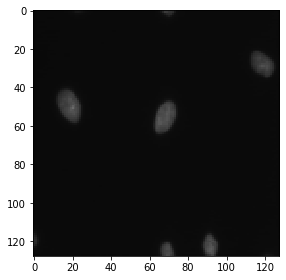

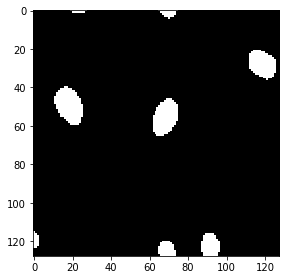

In [68]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [69]:
ix

280

In [33]:
import time
import sys
 
for i in range(5):
  print(i),
  sys.stdout.flush()
  #time.sleep(1)

0
1
2
3
4
